#### PART 1 : Load the recordings, find artefacts, resync ####

**Import all the librairies and functions**

In [1]:
# Importation of librairies and functions
import os
import importlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [2]:
# check some package versions for documentation and reproducibility
import sys
import mne
from matplotlib import __version__ as plt_version
import scipy
print('Python sys', sys.version)
print('pandas', pd.__version__)
print('numpy', np.__version__)
print('mne', mne.__version__)
print('sci-py', scipy.__version__)
print('matplotlib', plt_version)

Python sys 3.10.9 | packaged by conda-forge | (main, Feb  2 2023, 20:14:58) [MSC v.1929 64 bit (AMD64)]
pandas 1.5.3
numpy 1.23.5
mne 1.3.0
sci-py 1.10.0
matplotlib 3.6.3


In [4]:
def set_cd_repo_folder():
    """sets current working directory to main repo folder"""
    cd = os.getcwd()

    check = 0

    while os.path.basename(cd) != 'ReSync':

        cd = os.path.dirname(cd)
        check += 1
        if check > 10: raise ValueError('Repo path not found')
    
    os.chdir(cd)

    print(f'working directory changed to {os.getcwd()}')

    return os.getcwd()


In [5]:
project_path = set_cd_repo_folder()

working directory changed to c:\Users\Juliette\Research\Projects\Synchronization_project\Code\ReSync


In [6]:
# import custom-made functions
import functions.preprocessing as preproc
import functions.utils as utils
import functions.plotting as plot
import functions.find_artefacts as artefact
import functions.crop as crop
import functions.main_resync as resync

In [62]:
importlib.reload(plot)
importlib.reload(preproc)
importlib.reload(utils)
importlib.reload(artefact)
importlib.reload(crop)
importlib.reload(resync)

<module 'functions.main_resync' from 'c:\\Users\\Juliette\\Research\\Projects\\Synchronization_project\\Code\\ReSync\\functions\\main_resync.py'>

**Load your own LFP data:**

Resulting variables needed for subsequent analysis:
- LFP_array (np.ndarray, multi dimensional): the LFP recording which has to be aligned, containing all channels
- lfp_sig (np.ndarray, 1d): the channel containing the LFP signal from the hemisphere where the stimulation was delivered to create artefacts
- LFP_rec_ch_names (list): names of all the channels, in a list (will be used to annotate cropped recording)


In [8]:
# load pyPerceive functions
os.chdir(os.path.dirname(os.getcwd()))
os.chdir(os.path.join(os.getcwd(), 'PyPerceive'))
os.chdir(os.path.join(os.getcwd(), 'code'))
pyPerceive_path = os.getcwd()
print (f'working dir to go fetch PyPerceive functions:{pyPerceive_path}')

from PerceiveImport.classes import (
    main_class, modality_class, metadata_class,
    session_class, condition_class, task_class,
    contact_class, run_class
)
import PerceiveImport.methods.load_rawfile as load_rawfile
import PerceiveImport.methods.find_folders as find_folders
import PerceiveImport.methods.metadata_helpers as metaHelpers

#reset the proper working directory for the analysis
os.chdir(project_path)
print (f'working dir set back to:{project_path}')

working dir to go fetch PyPerceive functions:c:\Users\Juliette\Research\Projects\Synchronization_project\Code\PyPerceive\code
working dir set back to:c:\Users\Juliette\Research\Projects\Synchronization_project\Code\ReSync


In [64]:
# choose LFP file
sub036 = main_class.PerceiveData(
    sub = "036", 
    incl_modalities=['streaming'],
    incl_session = ["fu18m"],
    incl_condition =['m0s0','m0s1','m1s0','m1s1'],
    incl_task = ["rest"],
    # incl_contact = ["RingL", "SegmInterR", "SegmIntraR"],
    import_json=False,
    warn_for_metaNaNs=True,
    allow_NaNs_in_metadata=False
)

# define LFP data
LFP_rec = sub036.streaming.fu18m.m0s1.rest.run1.data
LFP_array = LFP_rec.get_data()
ch_i = 0 #choose index of the channel containing the stim artefacts (O for left hemisphere, 1 for right hemisphere)
lfp_sig = LFP_rec.get_data()[ch_i]
LFP_rec_ch_names = LFP_rec.ch_names

n_chan = len(LFP_rec.ch_names)
time_duration_LFP = (LFP_rec.n_times/LFP_rec.info['sfreq']).astype(float)
print(     
	f'The data object has:\n\t{LFP_rec.n_times} time samples,'      
	f'\n\tand a sample frequency of {LFP_rec.info["sfreq"]} Hz'      
	f'\n\twith a recording duration of {time_duration_LFP} seconds.'      
	f'\n\t{n_chan} channels were labeled as \n{LFP_rec.ch_names}.')
print(f'The channel containing artefacts has index {ch_i} and is named {LFP_rec.ch_names[ch_i]}')

add run 1
Creating RawArray with float64 data, n_channels=6, n_times=72313
    Range : 0 ... 72312 =      0.000 ...   289.248 secs
Ready.
add run 1
Creating RawArray with float64 data, n_channels=6, n_times=245625
    Range : 0 ... 245624 =      0.000 ...   982.496 secs
Ready.
add run 1
Creating RawArray with float64 data, n_channels=6, n_times=75063
    Range : 0 ... 75062 =      0.000 ...   300.248 secs
Ready.
add run 1
Creating RawArray with float64 data, n_channels=6, n_times=109000
    Range : 0 ... 108999 =      0.000 ...   435.996 secs
Ready.
add run 2
Creating RawArray with float64 data, n_channels=6, n_times=112375
    Range : 0 ... 112374 =      0.000 ...   449.496 secs
Ready.
The data object has:
	245625 time samples,
	and a sample frequency of 250.0 Hz
	with a recording duration of 982.5 seconds.
	6 channels were labeled as 
['LFP_L_03_STN_MT', 'LFP_R_03_STN_MT', 'LFP_L_03_STN_MT_PEAK15Hz_THR20-30_AVG3000ms', 'LFP_R_03_STN_MT_PEAK14Hz_THR20-30_AVG3000ms', 'STIM_L_110Hz_40us

**Load your own external data:**
(our external data recorder is a TMSi Data recorder.)

PM: NOTICE THE POP UP WINDOW AFTER RUNNING, TO SELECT THE FILE LOCATION

Resulting variables:
- external_file (np.ndarray, multi-dimensional): the complete external recording containing all channels recorded
- BIP_channel (np.ndarray, 1d): the channel containing the signal from the bipolar electrode used to pick up the artefacts on the IPG/cable
- external_rec_ch_names (list, same length as the number of channels in external_file): list of the channels names, to rename them accordingly after alignment

In [10]:
import functions.tmsi_poly5reader as poly5_reader
import functions.loading_TMSi as loading

In [65]:
TMSi_data = poly5_reader.Poly5Reader()  # open TMSi data from poly5
(BIP_channel,
 external_file,
 external_rec_ch_names) = loading.load_TMSi_artefact_channel(TMSi_data) # function adapted for our own data recorder, 
# to load all necessary variables

Reading file  C:/Users/Juliette/OneDrive - Charité - Universitätsmedizin Berlin/Recordings/TMSi files/sub-036/18MFU/sub036_18mfu_M0S1_BrStr_RestTap - 20230801T102331.DATA.Poly5
	 Number of samples:  2067133 
	 Number of channels:  38 
	 Sample rate: 2048 Hz
Done reading data.
Creating RawArray with float64 data, n_channels=38, n_times=2067133
    Range : 0 ... 2067132 =      0.000 ...  1009.342 secs
Ready.
The data object has:
	2067133 time samples,
	and a sample frequency of 2048.0 Hz
	with a recording duration of 1009.34228515625 seconds.
	38 channels were labeled as 
['ExG1', 'ExG2', 'ExG3', 'ExG4', 'ExG5', 'ExG6', 'ExG7', 'ExG8', 'ExG9', 'ExG10', 'ExG11', 'ExG12', 'ExG13', 'ExG14', 'ExG15', 'ExG16', 'Bip17', 'Bip18', 'Bip19', 'Bip20', 'Bip21', 'Bip22', 'Bip23', 'Bip24', 'Bip25', 'Bip26', 'Bip27', 'Bip28', 'Aux29', 'Aux30', 'Aux31', 'Empty', 'SaO2', 'Pleth', 'HRate', 'Status', 'Digi', 'Saw'].
the channel used to align datas is the channel named Bip25 and has index 24


**Align recordings:**

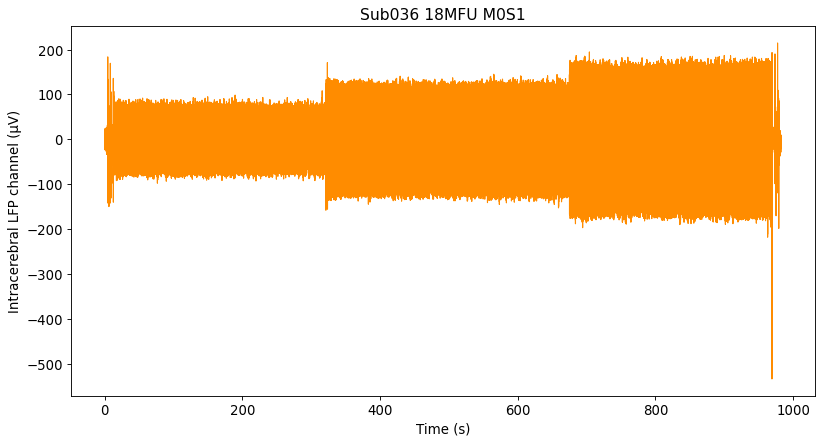

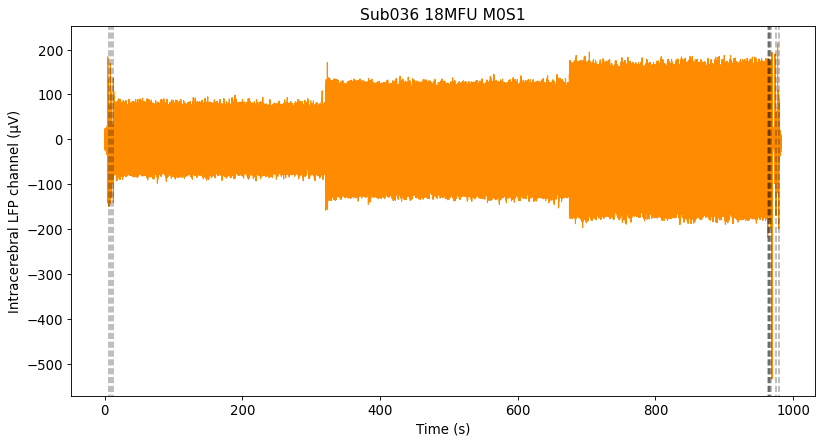

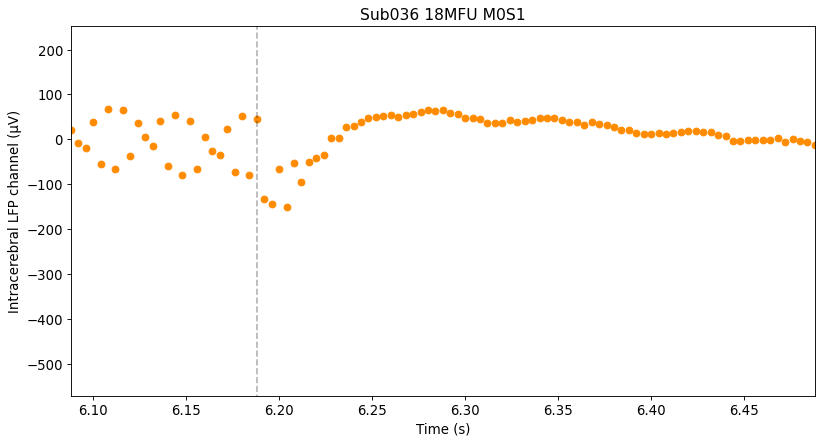

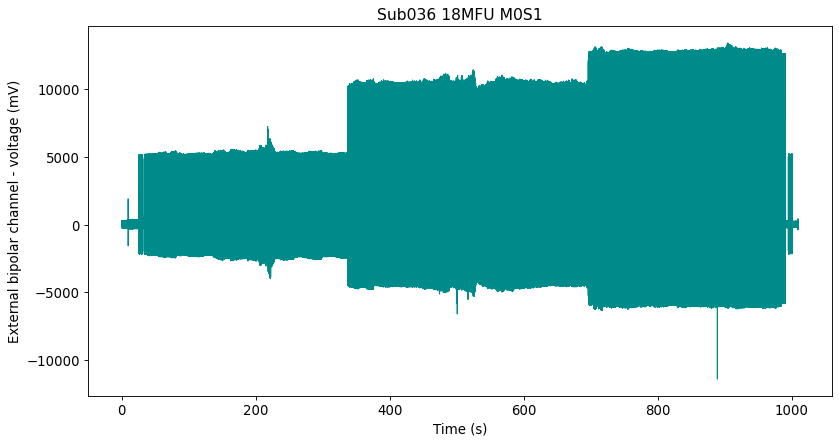

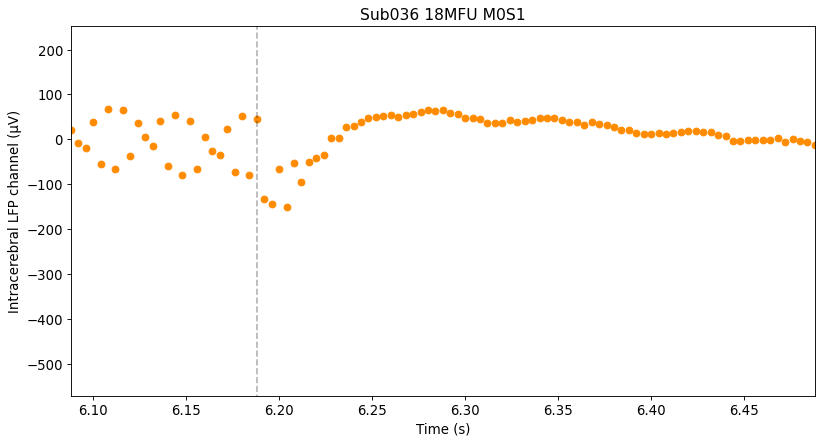

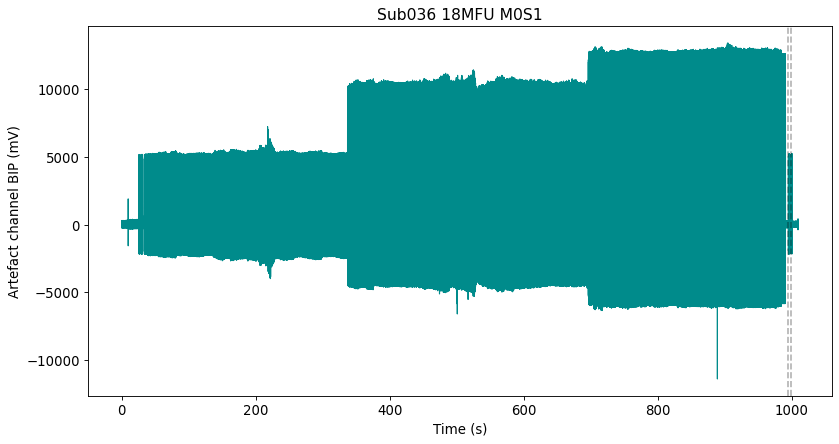

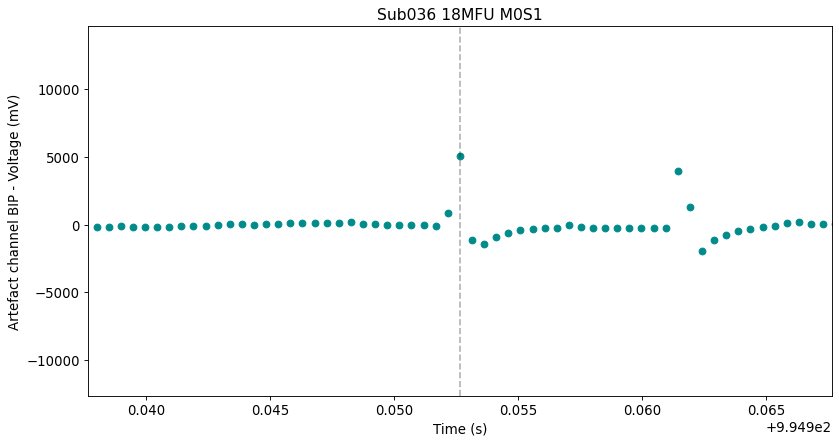

Alignment performed ! 
Please check carefully in all figures that the samples selected 
as start of the artefact are correct, and if they are not 
please correct parameters accordingly in the config file before re-running


In [68]:
(LFP_df_offset, 
 external_df_offset) = resync.run_resync(
    LFP_array=LFP_array,
    lfp_sig=lfp_sig,
    LFP_rec_ch_names=LFP_rec_ch_names,
    external_file=external_file,
    BIP_channel=BIP_channel,
    external_rec_ch_names=external_rec_ch_names,
    SHOW_FIGURES = True
)

#### PART 2 : Look for timeshift ####

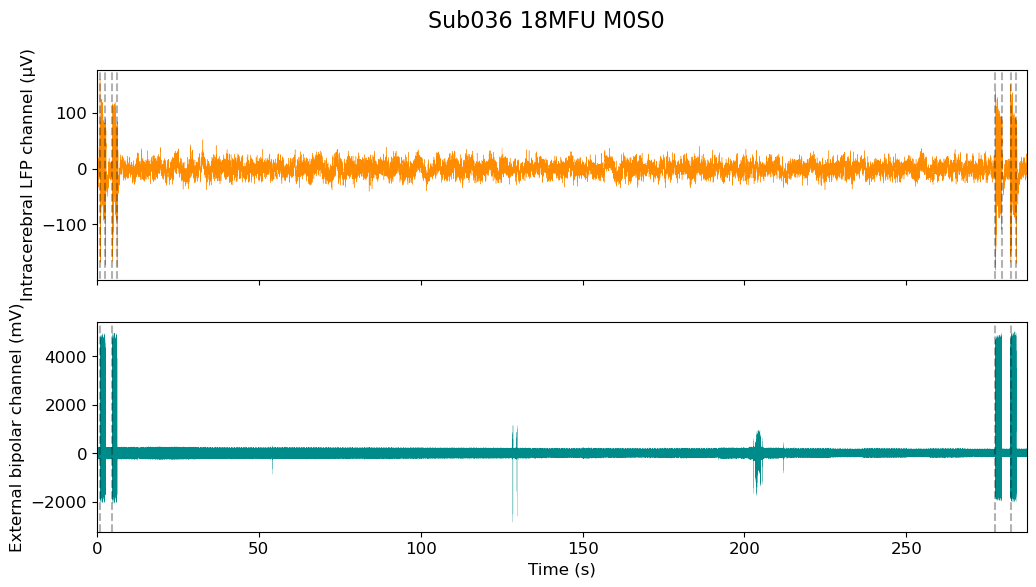

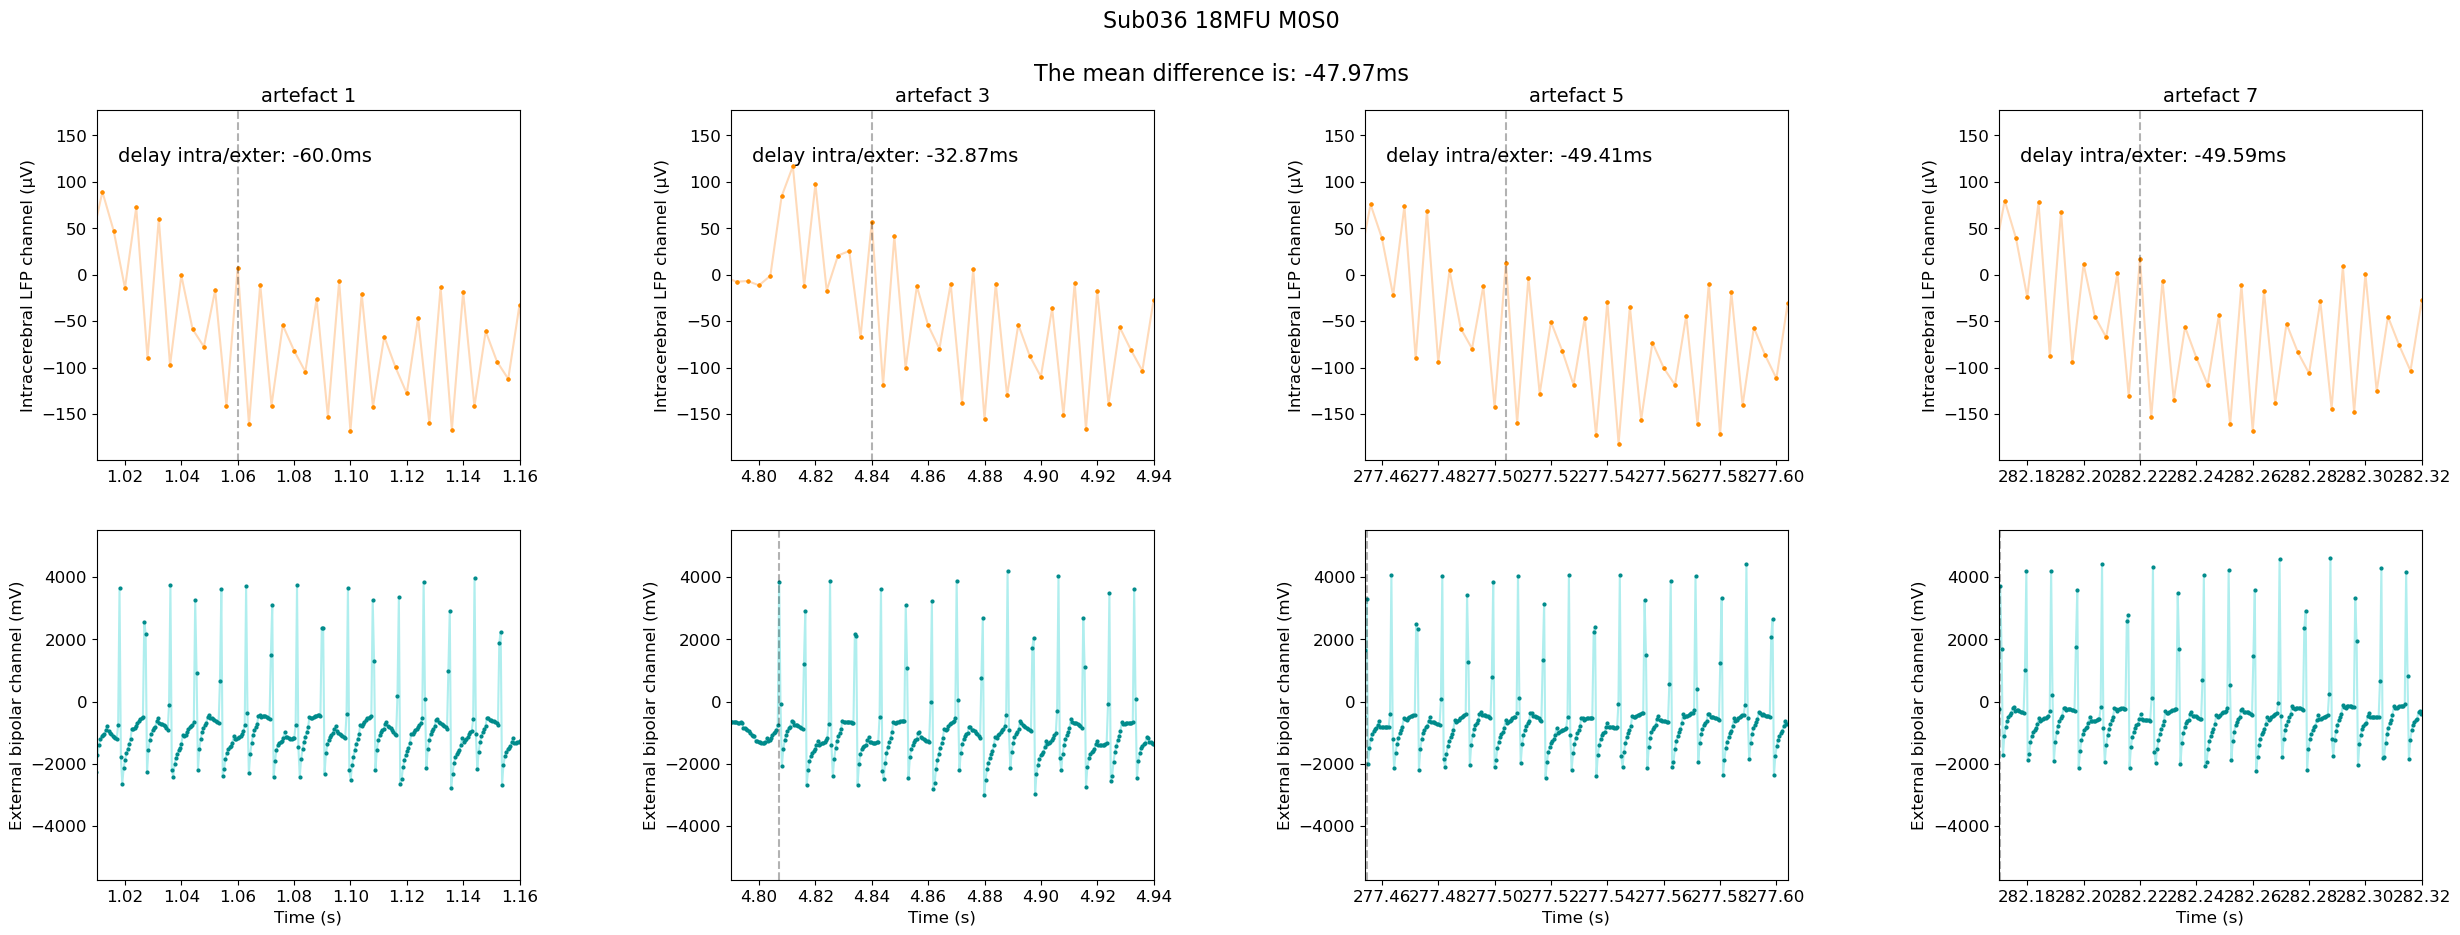

Timeshift analysis performed ! 
The result is: -49.589843750027285 ms delay at the last detected artefact, 
after a recording duration of 282.22s.


In [63]:
resync.run_timeshift_analysis(
    LFP_df_offset,
    external_df_offset,
    SHOW_FIGURES = True
)
